# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import tensorflow as tf
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings
from collections import Counter
from utils.textnormalization import TextNormalization
from utils.machinelearning import machine_learning_model, fit_model
from utils.deeplearning import model_compile, model_fit, lstm_, gru_, bidirectional_lstm
from utils.plot_model_changes import plot_changes
from utils.sentimentinformation import sentiment_percentage, sentiment_counts
from utils.wordcloud import wordcloud
from utils.most_frequent_word_plot import bar_plot
from utils.deeplearning_preprcosesing import  deeplearning_preprcosesing_
from utils.word_vector import word_vector_
from utils.confusion_matrix import confusion_matrix_, confusion_matrix_display
from utils.generate_poitive_negative import generate_poitive_negative
from utils.performance_metrics import accuracy_score, precision_score, sensitivity_score, specificity_score, f1_score, error_rate, performance_metrics_data_frame
from utils.model_inference import machine_learning_inference, deep_learning_inference
from utils.transformers_ import sentiment_analysis_transformers
pd.options.display.max_rows = 100
pd.options.display.max_columns =None 
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

# Download Some Packages

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Ignore Warnings

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings(action='ignore')

# Read Data

In [4]:
Corpus = pd.read_csv('balanced-reviews-utf8.tsv', sep="\t")
Corpus['rating'].value_counts()
sentiment = []
for i in Corpus['rating']:
    if i == 1 or i == 2:
        sentiment.append('Negative')
    else:
        sentiment.append('Positive')
Corpus['Sentiment'] = sentiment
Corpus.rename(columns={'review': 'Review'}, inplace=True)
Corpus = Corpus[['Review', 'Sentiment']]
Corpus['Review'] = Corpus['Review'].astype(str)
Corpus = Corpus.sample(frac=1, random_state=55, ignore_index=True)
Corpus.index = Corpus.index + 1 
Corpus.tail(10)

,Review,Sentiment
105689,ممتاز. نظافة المكان. عدم وجود واي فاي مجاني,Positive
105690,“لا تعتمد علي فنادق الاصيل لعدم احترامهم الحجو...,Negative
105691,“لابأس”. أقرب من الحرم. ازعاج الآخرين بالغرف,Negative
105692,جيد. الارضية باركيهالموقع جيد. المكيفات من نوع...,Positive
105693,“تجربة سيئة جدا”. قرب الفندق من محطة مترو صلاح...,Negative
105694,“زيارتي للفندق هذه لن تتكرر ولو بالمجان”. بدون...,Negative
105695,“سئ”. . زي الزفت الغرف سيئة جدا السراير غير مر...,Negative
105696,“جميل ورائع”. كل شي تمام النظافه والخدمه والمو...,Positive
105697,“تجربة سيئة”. سيء للغاية. موظفين الاستقبالنظاف...,Negative
105698,“الهدوء الجمال”. الهدوء وقربه من التسوق. لا يوجد,Negative


# Validation Data

In [3]:
reviews = ["لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.",
       "الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.",
        "كانت الأسرة في الغرفة مريحة جدًا.",
        "الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.",
        "كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.",
        "الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.",
        "الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.",
        "الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.",
        "استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.",
        "المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إلى تجديدات عاجلة.",]

# Sentiment Information

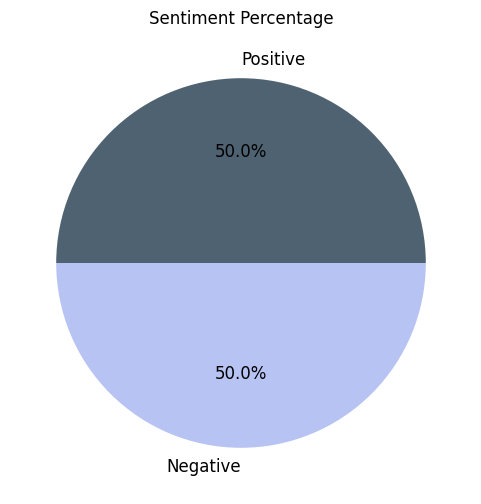

In [6]:
sentiment_percentage(Corpus, 'Sentiment', (6, 6))

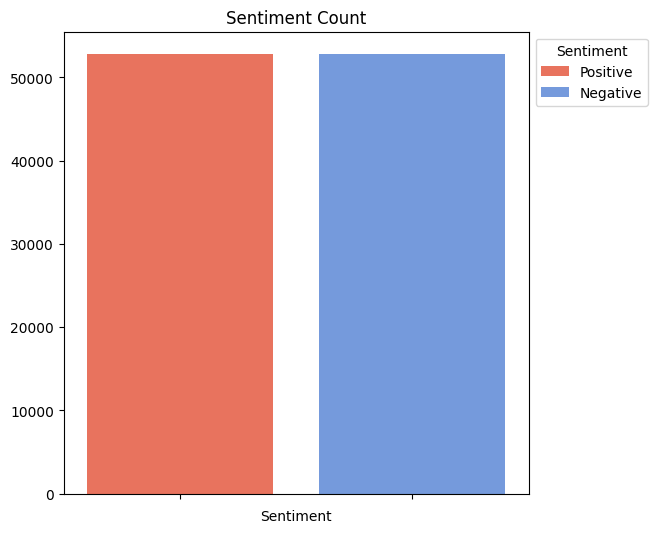

In [7]:
sentiment_counts(Corpus, 'Sentiment', (6, 6))

# Number Of Sentences

In [8]:
Corpus['NumberOfSentences'] = Corpus['Review'].apply(lambda n:len(sent_tokenize(n)))
Corpus.drop(Corpus[Corpus["NumberOfSentences"] == 0].index, inplace = True)
Corpus['NumberOfSentences'].sum()

316380

# Average Number Of Sentences

In [9]:
AverageNumberOfSentence = int(np.round(Corpus["NumberOfSentences"].mean()))
AverageNumberOfSentence

3

# Maximum Number Of Sentences

In [10]:
MaximumNumberOfSentence = Corpus["NumberOfSentences"].max()
MaximumNumberOfSentence

93

# Minimum Number Of Sentences

In [11]:
MinimumNumberOfSentence = Corpus["NumberOfSentences"].min()
MinimumNumberOfSentence

1

# Number Of Words Before Review Normalization

In [12]:
Corpus["Number of Words 1"] = Corpus["Review"].apply(lambda n:len(word_tokenize(n)))
Corpus["Number of Words 1"].sum()

2886975

# Average Number Of Words Before Review Normalization

In [13]:
AverageNaumberOfWords1 = int(np.round((Corpus["Number of Words 1"].mean())))
AverageNaumberOfWords1

27

# Maximum Number Of Word Before Review Normalization

In [14]:
MaximumNaumberOfWords1 = Corpus["Number of Words 1"].max()
MaximumNaumberOfWords1

623

# Minimum Number Of Words Before Review Normalization

In [15]:
MimimumNaumberOfWords1 = Corpus["Number of Words 1"].min()
MimimumNaumberOfWords1

3

# Number Of Charachters Before Review Normalization

In [16]:
Corpus["Number of Charachters 1"] = Corpus["Review"].apply(lambda n:sum(chr.isalpha() for chr in n))
Corpus["Number of Charachters 1"].sum()

11484118

# Average Number Of Charachters Before Review Normalization

In [17]:
AverageNumberOfCharachters1 = int(np.round(Corpus["Number of Charachters 1"].mean()))
AverageNumberOfCharachters1

109

# Maximum Number Of Charachters Before Review Normalization

In [18]:
MaximumNumberOfCharachters1 = Corpus['Number of Charachters 1'].max() 
MaximumNumberOfCharachters1

2705

# Minimum Number Of Charachters Before Review Normalization

In [19]:
MinimumNumberOfCharachters1 = Corpus['Number of Charachters 1'].min() 
MinimumNumberOfCharachters1

0

In [20]:
Corpus[Corpus['Number of Charachters 1'] == 0]

,Review,Sentiment,NumberOfSentences,Number of Words 1,Number of Charachters 1
3245,“👍🏻”. 👍🏻. 👍🏻,Positive,3,7,0
7880,“*”. *. *,Negative,3,7,0
30736,“....”. ............ .............,Negative,2,6,0
34960,“3 . .,Positive,2,4,0
39587,“. .,Negative,2,3,0
49228,"“,,,,,,,,,,”. . ,,,,,,",Negative,3,20,0
50038,“-”. -. -,Positive,3,7,0
53698,“9. .,Positive,2,4,0
61507,“...”. .... ....,Positive,2,6,0
79917,“4 😑”. . 4😑,Negative,3,7,0


# Most Frequent Words Before Review Normalization

In [21]:
MostFrequentWord1 = Counter((Corpus['Review']).str.split().explode()).most_common(15)
MostFrequentWordDF1 = pd.DataFrame(MostFrequentWord1, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF1

,Word,Count
1,من,50502
2,في,48501
3,الفندق,33246
4,لا,27415
5,.,26495
6,جدا,25571
7,و,21856
8,غير,18140
9,كل,17111
10,على,15785


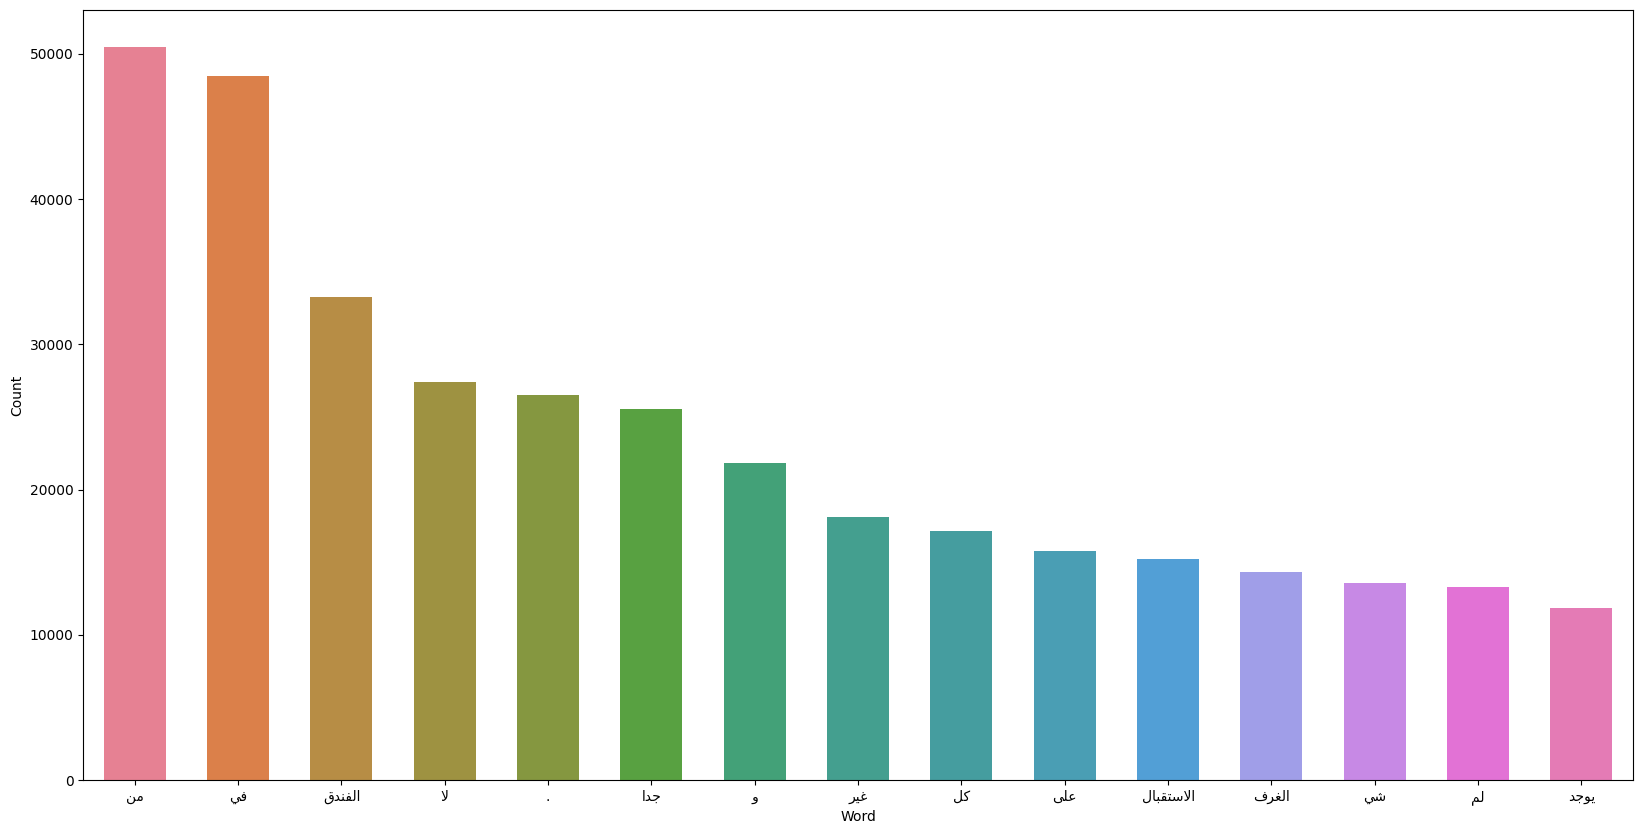

In [22]:
bar_plot(data=MostFrequentWordDF1, text = 'Word', x = 'Word', y='Count')

# Review Normalization

In [23]:
normalization = TextNormalization(remove_emojis = True,
                                  remove_hashtags = True,  
                                       remove_emails = True,
                                       remove_url = True,
                                       remove_mention = True,
                                       remove_html_tags = True,
                                       remove_new_line_char = True,
                                       remove_duplicate_word = True,
                                       remove_single_letter = True,
                                       remove_duplicated_letter = True,
                                       normalize_gaf = True,
                                       normalize_pe = True,
                                       normalize_che = True,
                                       normalize_kurdish_waw = True,
                                       decrease_number_of_consecutive_reapted_letter = True,
                                       remove_punctuations = True,
                                       normalize_arabic_unicode = True,
                                       remove_unicode_and_special_character = True,
                                       remove_stop_words = True,
                                       remove_number = True,
                                       arabic_spell_correction = False, 
                                       remove_arabic_diacritics = True,
                                       remove_non_arabic = True,
                                       remove_arabic_tatweel = True,
                                       normalize_alef = True,
                                       normalize_alef_maqsura = True,
                                       normalize_teh_marbuta = True,
                                       remove_longest_than = True,
                                       remove_whitespace = True)

Corpus['Normalized_Review'] = Corpus['Review'].map(normalization.text_normalization)
Corpus.dropna(axis=1, inplace=True)
Corpus.to_csv('Normalized Corpus.csv')
Corpus.tail(5)

,Review,Sentiment,NumberOfSentences,Number of Words 1,Number of Charachters 1,Normalized_Review
105694,“زيارتي للفندق هذه لن تتكرر ولو بالمجان”. بدون...,Negative,3,55,232,للفندق تتكرر ولو مبالغه يعجبني بالفندق شي السع...
105695,“سئ”. . زي الزفت الغرف سيئة جدا السراير غير مر...,Negative,3,20,71,زي الزفت الغرف سيئه السراير مريحه الفرش متهالك...
105696,“جميل ورائع”. كل شي تمام النظافه والخدمه والمو...,Positive,3,15,50,شي تمام النظافه والخدمه والموقع والتعامل شي
105697,“تجربة سيئة”. سيء للغاية. موظفين الاستقبالنظاف...,Negative,3,23,117,لغايه موظفين الاستقبالنظافه الجناحضيق المواقفض...
105698,“الهدوء الجمال”. الهدوء وقربه من التسوق. لا يوجد,Negative,3,12,37,وقربه التسوق يوجد


# Number Of Unique Words

In [24]:
UniqueWords = set()
for word in Corpus['Normalized_Review'].str.split():
    UniqueWords.update(word)
len(UniqueWords)

106246

# WordCloud

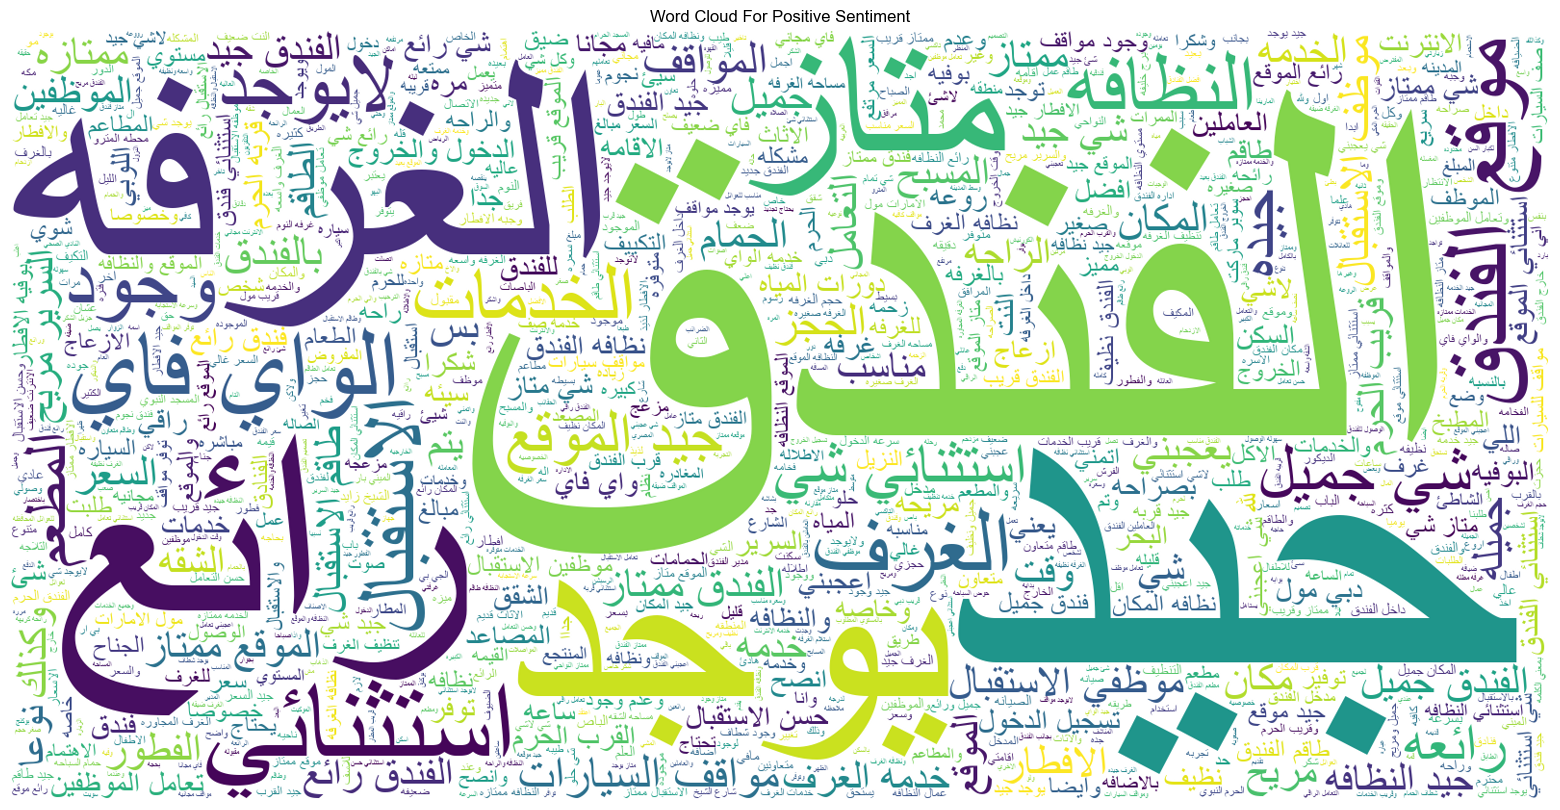

In [25]:
wordcloud(data=Corpus, target='Positive', width=1600, hieght=800, review='Normalized_Review', max_words= 1000)

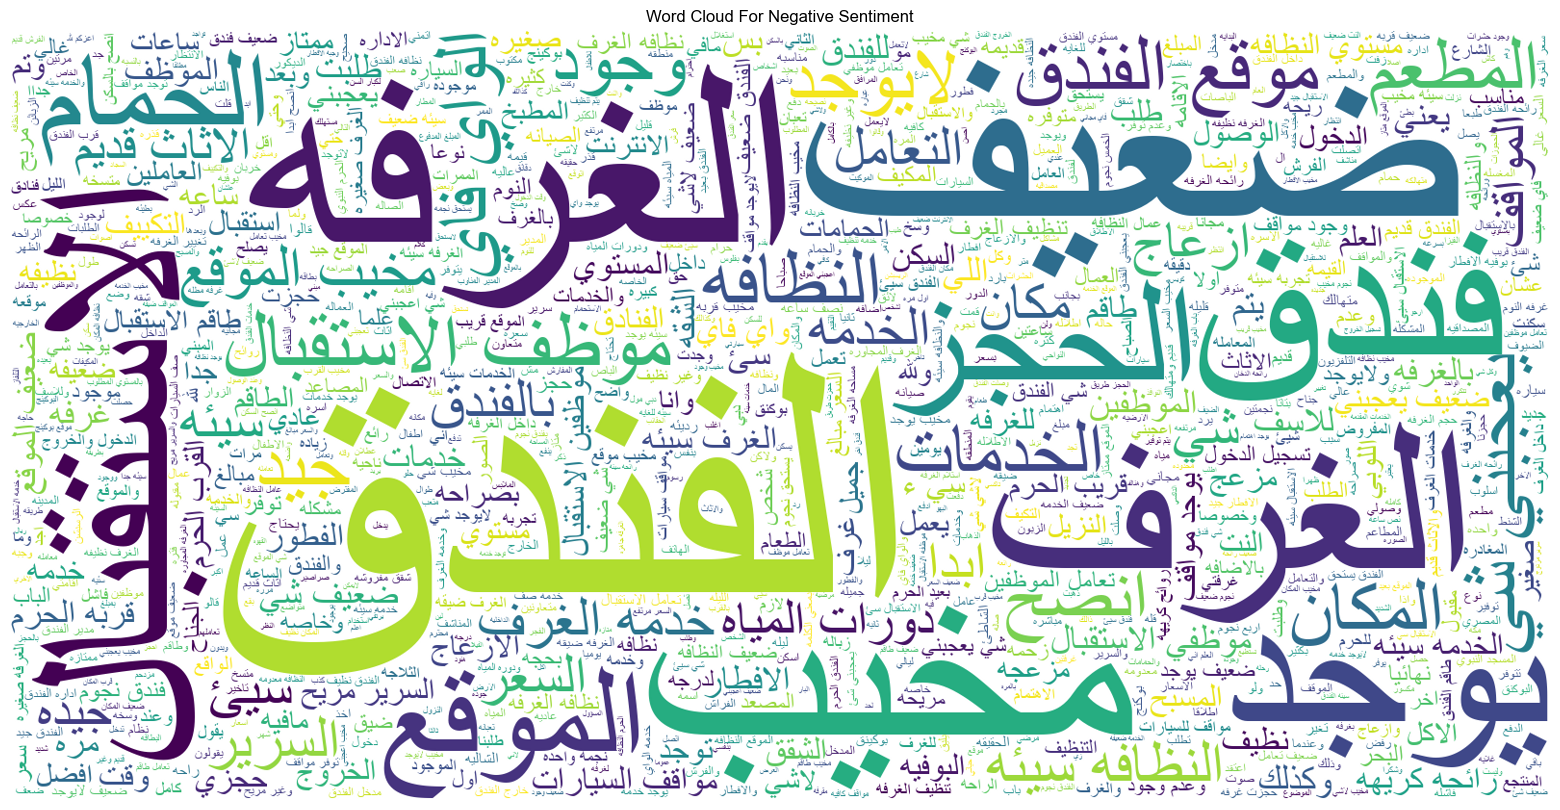

In [26]:
wordcloud(data=Corpus, target='Negative', width=1600, hieght=800, review='Normalized_Review', max_words= 1000)

# Number Of Words After Review Normalization

In [27]:
Corpus["Number of Words 2"] = Corpus["Normalized_Review"].apply(lambda n:len(word_tokenize(n)))
Corpus.drop(Corpus[Corpus["Number of Words 2"] == 0].index, inplace = True)
Corpus["Number of Words 2"].sum()

1585007

# Average Number Of Words After Review Normalization

In [28]:
AverageNaumberOfWords2 = int(np.round((Corpus["Number of Words 2"].mean())))
AverageNaumberOfWords2

15

# Maximum Number Of Word After Review Normalization

In [29]:
MaximumNaumberOfWords2 = Corpus["Number of Words 2"].max()
MaximumNaumberOfWords2

373

# Minimum Number Of Words After Review Normalization

In [30]:
MimimumNaumberOfWords2 = Corpus["Number of Words 2"].min()
MimimumNaumberOfWords2

1

# Number Of Charachters After Review Normalization

In [31]:
Corpus["Number of Charachters 2"] = Corpus["Normalized_Review"].str.len()
Corpus["Number of Charachters 2"].sum()

9902924

# Average Number Of Charachters After Review Normalization

In [32]:
AverageNumberOfCharachters2 = int(np.round(Corpus["Number of Charachters 2"].mean()))
AverageNumberOfCharachters2

94

# Maximum Number Of Charachters After Review Normalization

In [33]:
MaximumNumberOfCharachters2 = Corpus['Number of Charachters 2'].max() 
MaximumNumberOfCharachters2

2347

# Minimum Number Of Charachters After Review Normalization

In [34]:
MinimumNumberOfCharachters2 = Corpus['Number of Charachters 2'].min() 
MinimumNumberOfCharachters2

2

# Most Frequent Words After Review Normalization

In [35]:
MostFrequentWord2 = Counter((Corpus['Normalized_Review']).str.split().explode()).most_common(15)
MostFrequentWordDF2 = pd.DataFrame(MostFrequentWord2, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF2

,Word,Count
1,الفندق,36481
2,الغرفه,17203
3,شي,16663
4,الاستقبال,16626
5,جيد,16385
6,الغرف,15439
7,ضعيف,14237
8,الموقع,13293
9,يوجد,12321
10,النظافه,11781


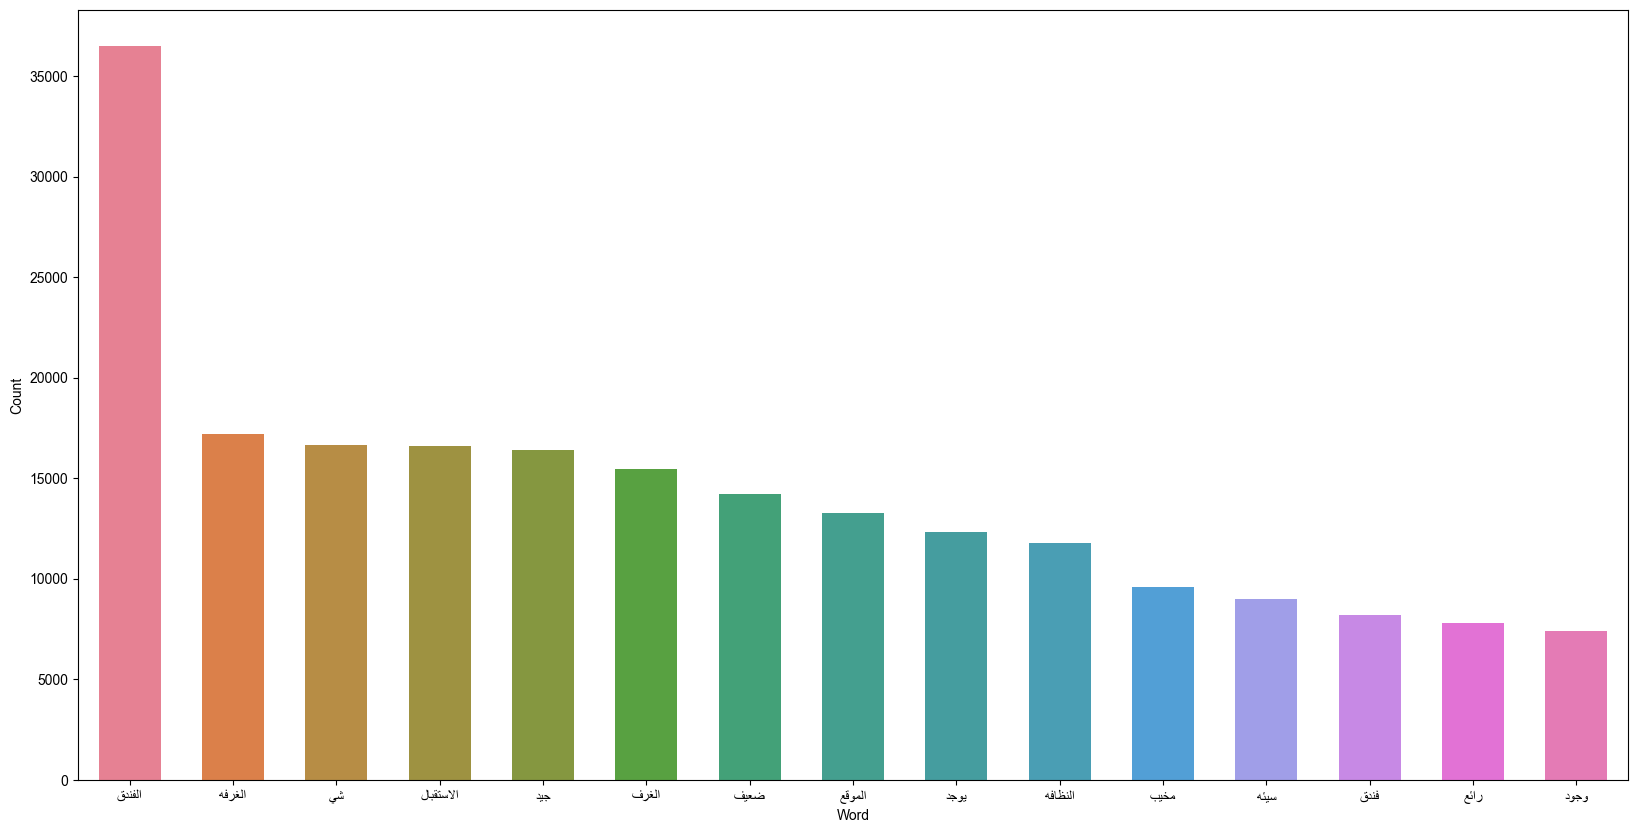

In [36]:
bar_plot(data=MostFrequentWordDF2, text = 'Word', x = 'Word', y='Count')

# Most Frequent Words Of Each Sentiment

**1-Positive**

In [37]:
Positive = Corpus[Corpus['Sentiment'] == 'Positive']

In [38]:
PositiveMostFrequentWord = Counter((Positive['Normalized_Review']).str.split().explode()).most_common(10)
PositiveMostFrequentWordDF = pd.DataFrame(PositiveMostFrequentWord, columns=('Word', 'Count'), index=range(1, 11))
PositiveMostFrequentWordDF

,Word,Count
1,الفندق,16575
2,جيد,13344
3,شي,8356
4,رائع,7425
5,استثنائي,7309
6,الاستقبال,7206
7,الموقع,6424
8,الغرفه,6261
9,ممتاز,6156
10,الغرف,5886


**2-Negative**

In [39]:
Negative = Corpus[Corpus['Sentiment'] == 'Negative']

In [40]:
NegativeMostFrequentWord = Counter((Negative['Normalized_Review']).str.split().explode()).most_common(10)
NegativeMostFrequentWordDF = pd.DataFrame(NegativeMostFrequentWord, columns=('Word', 'Count'), index=range(1, 11))
NegativeMostFrequentWordDF

,Word,Count
1,الفندق,19906
2,ضعيف,13190
3,الغرفه,10942
4,مخيب,9603
5,الغرف,9553
6,الاستقبال,9420
7,سيئه,8321
8,شي,8307
9,يوجد,7890
10,الموقع,6869


# Part Of Speech Tagging (POS)

In [41]:
word_ = list(UniqueWords)
pos = nltk.pos_tag(word_)
word = []
tag = []

In [42]:
for i in pos:
    word.append(i[0])
    tag.append(i[1])

In [43]:
pos = pd.DataFrame(zip(word, tag), columns=['Word', 'Tag'])
pos.head()

,Word,Tag
0,سيئفرش,JJ
1,ونقلوني,NNP
2,لاحظته,NNP
3,بازعاجي,NNP
4,وغيرو,NNP


In [44]:
pos['Tag'].value_counts()

Tag
NNP    106244
JJ          1
NN          1
Name: count, dtype: int64

# Bigrams

In [45]:
Corpus['Bigrams'] = Corpus['Normalized_Review'].apply(lambda x: list(nltk.bigrams(x.split( ))))
Corpus

,Review,Sentiment,NumberOfSentences,Number of Words 1,Number of Charachters 1,Normalized_Review,Number of Words 2,Number of Charachters 2,Bigrams
1,استثنائي. . ادوات النظافه في دورة المياه، الصا...,Positive,3,13,57,استثنائي ادوات النظافه المياه الصابون الشامبو ...,7,53,"[(استثنائي, ادوات), (ادوات, النظافه), (النظافه..."
2,مخيب للأمل. . الاستقبال عند وصولي في البداية ق...,Negative,3,27,104,مخيب الاستقبال وصولي البدايه غرف متوفره اصريت ...,11,69,"[(مخيب, الاستقبال), (الاستقبال, وصولي), (وصولي..."
3,“رحلة عمرة مميزه”. اطلالته على الحرم المكى ورؤ...,Positive,3,22,84,عمره اطلالته الحرم المكي ورؤيه الكعبه مباشره ا...,13,84,"[(عمره, اطلالته), (اطلالته, الحرم), (الحرم, ال..."
4,"“موقع وقيمة رائعة”. الموقع أكثر من رائع , نظاف...",Positive,3,26,101,وقيمه الموقع رائع نظافه الغرف والترتيب فخامه م...,12,76,"[(وقيمه, الموقع), (الموقع, رائع), (رائع, نظافه..."
5,“سلطان”. . انه يوجد في الموقع خدمة مجالسة الاط...,Positive,3,16,53,يوجد الموقع خدمه مجالسه الاطفال تتوفر الفندق,7,44,"[(يوجد, الموقع), (الموقع, خدمه), (خدمه, مجالسه..."
...,...,...,...,...,...,...,...,...,...
105694,“زيارتي للفندق هذه لن تتكرر ولو بالمجان”. بدون...,Negative,3,55,232,للفندق تتكرر ولو مبالغه يعجبني بالفندق شي السع...,37,217,"[(للفندق, تتكرر), (تتكرر, ولو), (ولو, مبالغه),..."
105695,“سئ”. . زي الزفت الغرف سيئة جدا السراير غير مر...,Negative,3,20,71,زي الزفت الغرف سيئه السراير مريحه الفرش متهالك...,12,71,"[(زي, الزفت), (الزفت, الغرف), (الغرف, سيئه), (..."
105696,“جميل ورائع”. كل شي تمام النظافه والخدمه والمو...,Positive,3,15,50,شي تمام النظافه والخدمه والموقع والتعامل شي,7,43,"[(شي, تمام), (تمام, النظافه), (النظافه, والخدم..."
105697,“تجربة سيئة”. سيء للغاية. موظفين الاستقبالنظاف...,Negative,3,23,117,لغايه موظفين الاستقبالنظافه الجناحضيق المواقفض...,15,112,"[(لغايه, موظفين), (موظفين, الاستقبالنظافه), (ا..."


# Split The Dataset Into X And y

In [46]:
X, y = Corpus['Normalized_Review'], Corpus['Sentiment']

# Encoding Dependent Variables (Y) Into Integer

In [47]:
le = LabelEncoder()
y = le.fit_transform(y)

# Split The Dataset Into Training And Testing

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=44)

# Vectorizer

In [49]:
Vectorizer = TfidfVectorizer()
X_train_vec = Vectorizer.fit_transform(X_train)
X_test_vec = Vectorizer.transform(X_test)

# Word Mapping

In [50]:
Word_mapping = Vectorizer.vocabulary_
Word_mapping_ =pd.DataFrame((list(Word_mapping.items())), columns=['Word', 'Mapping'])
Word_mapping_.tail()

,Word,Mapping
92752,لاتنغروا,53189
92753,بوقنك,29595
92754,طوليه,45677
92755,قصرها,50687
92756,وسخر,80769


# Machine Learning

**1-Naive Bayes**

In [51]:
Algorithm = MultinomialNB(alpha= 1)
model_1 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_1, X_train=X_train_vec, y_train=y_train)

MultinomialNB(alpha=1)

In [52]:
y_predNB = model_1.predict(X_test_vec)
False_PositiveNB, True_PositiveNB, False_NegativeNB, True_NegativeNB = generate_poitive_negative(y_test = y_test, y_pred=y_predNB)

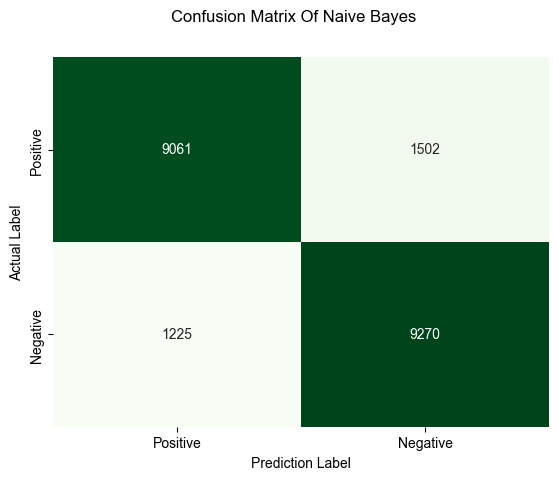

In [53]:
ConfusionMatrixNB = confusion_matrix_(true_positive=True_PositiveNB, false_positive=False_PositiveNB, true_negative=True_NegativeNB, false_negative=False_NegativeNB)
confusion_matrix_display(confusion_matrix = ConfusionMatrixNB, name = 'Naive Bayes')

In [54]:
AccuracyNB = accuracy_score(True_Positive = True_PositiveNB, True_Negative = True_NegativeNB, False_Positive =False_PositiveNB, False_Negative = False_NegativeNB)
PrecisionNB= precision_score(True_Positive = True_PositiveNB, False_Positive= False_PositiveNB)

SensitivityNB = sensitivity_score(True_Positive = True_PositiveNB,  False_Negative = False_NegativeNB)
SpecificityNB = specificity_score(True_Negative = True_NegativeNB, False_Positive = False_PositiveNB)

F1ScoreNB = f1_score(True_Positive = True_PositiveNB, False_Negative = False_NegativeNB, False_Positive = False_PositiveNB)
ErrorNB = error_rate(True_Positive = True_PositiveNB, True_Negative = True_NegativeNB, False_Positive =False_PositiveNB, False_Negative = False_NegativeNB)

In [55]:
performance_metrics_data_frame(Accuracy = AccuracyNB, Precision = PrecisionNB, Sensitivity = SensitivityNB, Specificity = SpecificityNB, F1Score = F1ScoreNB, Error = ErrorNB)

,Values
Accuracy,0.870501
Precision,0.857806
Sensitivity,0.880906
Specificity,0.860564
F1Score,0.869202
Error,0.129499


**2-Logistic Regression**

In [56]:
Algorithm = LogisticRegression()
model_2 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_2, X_train=X_train_vec, y_train=y_train)

LogisticRegression()

In [57]:
y_predLR = model_2.predict(X_test_vec)

In [58]:
False_PositiveLR, True_PositiveLR, False_NegativeLR, True_NegativeLR = generate_poitive_negative(y_test= y_test, y_pred=y_predLR)

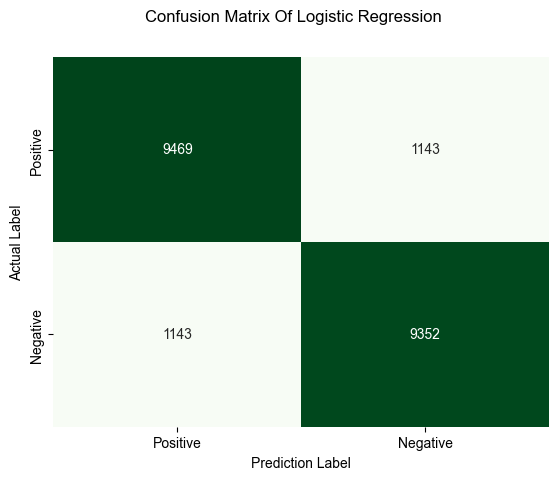

In [59]:
ConfusionMatrixLR = confusion_matrix_(true_positive= True_PositiveLR, false_positive=False_NegativeLR, true_negative=True_NegativeLR, false_negative=False_NegativeLR)
confusion_matrix_display(confusion_matrix = ConfusionMatrixLR, name = 'Logistic Regression')

In [60]:
AccuracyLR = accuracy_score(True_Positive = True_PositiveLR, True_Negative = True_NegativeLR, False_Positive =False_PositiveLR, False_Negative = False_NegativeLR)
PrecisionLR= precision_score(True_Positive = True_PositiveLR, False_Positive= False_PositiveLR)

SensitivityLR = sensitivity_score(True_Positive = True_PositiveLR,  False_Negative = False_NegativeLR)
SpecificityLR = specificity_score(True_Negative = True_NegativeLR, False_Positive = False_PositiveLR)

F1ScoreLR = f1_score(True_Positive = True_PositiveLR, False_Negative = False_NegativeLR, False_Positive = False_PositiveLR)
ErrorLR = error_rate(True_Positive = True_PositiveLR, True_Negative = True_NegativeLR, False_Positive =False_PositiveLR, False_Negative = False_NegativeLR)

In [61]:
performance_metrics_data_frame(Accuracy = AccuracyLR, Precision = PrecisionLR, Sensitivity = SensitivityLR, Specificity = SpecificityLR, F1Score = F1ScoreLR, Error = ErrorLR)

,Values
Accuracy,0.893770
Precision,0.896431
Sensitivity,0.892292
Specificity,0.895271
F1Score,0.894357
Error,0.106230


**3-Decision Tree**

In [62]:
Algorithm = DecisionTreeClassifier(criterion='gini')
model_3 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_3, X_train=X_train_vec, y_train=y_train)

DecisionTreeClassifier()

In [63]:
y_predDT = model_3.predict(X_test_vec)

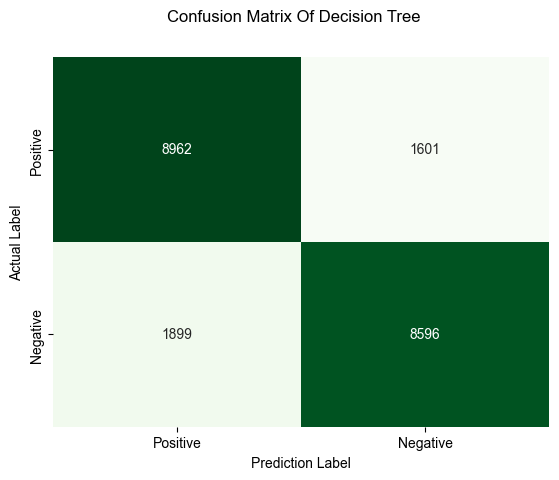

In [64]:
False_PositiveDT, True_PositiveDT, False_NegativeDT, True_NegativeDT = generate_poitive_negative(y_test = y_test, y_pred=y_predDT)
ConfusionMatrixDT = confusion_matrix_(false_positive=False_PositiveDT, true_positive=True_PositiveDT, false_negative=False_NegativeDT, true_negative=True_NegativeDT)
confusion_matrix_display(confusion_matrix = ConfusionMatrixDT, name = 'Decision Tree')

In [65]:
AccuracyDT = accuracy_score(True_Positive = True_PositiveDT, True_Negative = True_NegativeDT, False_Positive =False_PositiveDT, False_Negative = False_NegativeDT)
PrecisionDT= precision_score(True_Positive = True_PositiveDT, False_Positive =False_PositiveDT)

SensitivityDT = sensitivity_score(True_Positive = True_PositiveDT,  False_Negative = False_NegativeDT)
SpecificityDT = specificity_score(True_Negative = True_NegativeDT, False_Positive = False_PositiveDT)

F1ScoreDT = f1_score(True_Positive = True_PositiveDT, False_Negative = False_NegativeDT, False_Positive = False_PositiveDT)
ErrorDT = error_rate(True_Positive = True_PositiveDT, True_Negative = True_NegativeDT, False_Positive =False_PositiveDT, False_Negative = False_NegativeDT)

In [66]:
performance_metrics_data_frame(Accuracy = AccuracyDT, Precision = PrecisionDT, Sensitivity = SensitivityDT, Specificity = SpecificityDT, F1Score = F1ScoreDT, Error = ErrorDT)

,Values
Accuracy,0.833792
Precision,0.848433
Sensitivity,0.825154
Specificity,0.842993
F1Score,0.836632
Error,0.166208


**4-K Nearest Neighbors**

In [67]:
Algorithm =KNeighborsClassifier(metric='cosine', n_neighbors=5)
model_4 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_4, X_train=X_train_vec, y_train=y_train)

KNeighborsClassifier(metric='cosine')

In [68]:
y_predKNN = model_4.predict(X_test_vec)

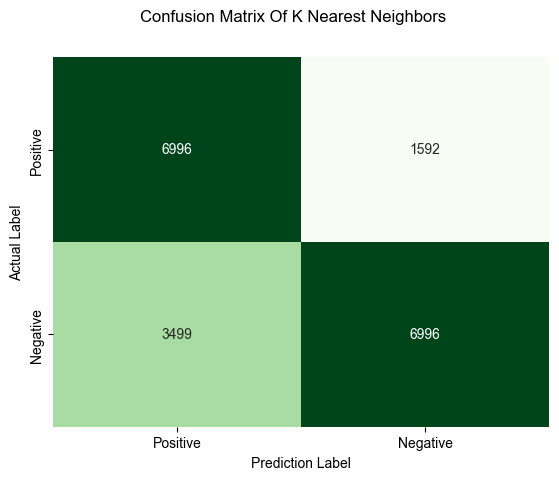

In [69]:
False_PositiveKNN, True_PositiveKNN, False_NegativeKNN, True_NegativeKNN = generate_poitive_negative(y_pred= y_predKNN, y_test=y_test)
ConfusionMatrixKNN = confusion_matrix_(true_positive=True_NegativeKNN, false_positive=False_PositiveKNN, true_negative=True_NegativeKNN, false_negative=False_NegativeKNN)
confusion_matrix_display(confusion_matrix = ConfusionMatrixKNN, name = 'K Nearest Neighbors')

In [70]:
AccuracyKNN = accuracy_score(True_Positive = True_PositiveKNN, True_Negative = True_NegativeKNN, False_Positive =False_PositiveKNN, False_Negative = False_NegativeKNN)
PrecisionKNN= precision_score(True_Positive = True_PositiveKNN, False_Positive =False_PositiveKNN)

SensitivityKNN = sensitivity_score(True_Positive = True_PositiveKNN,  False_Negative = False_NegativeKNN)
SpecificityKNN = specificity_score(True_Negative = True_NegativeKNN, False_Positive = False_PositiveKNN)

F1ScoreKNN = f1_score(True_Positive = True_PositiveKNN, False_Negative = False_NegativeKNN, False_Positive = False_PositiveKNN)
ErrorKNN = error_rate(True_Positive = True_PositiveKNN, True_Negative = True_NegativeKNN, False_Positive =False_PositiveKNN, False_Negative = False_NegativeKNN)

In [71]:
performance_metrics_data_frame(Accuracy = AccuracyKNN, Precision = PrecisionKNN, Sensitivity = SensitivityKNN, Specificity = SpecificityKNN, F1Score = F1ScoreKNN, Error = ErrorKNN)

,Values
Accuracy,0.758239
Precision,0.849285
Sensitivity,0.719407
Specificity,0.814625
F1Score,0.778969
Error,0.241761


**5-Random Forest**

In [72]:
Algorithm = RandomForestClassifier(criterion = 'entropy', n_estimators=100)
model_5 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_5, X_train=X_train_vec, y_train=y_train)

RandomForestClassifier(criterion='entropy')

In [73]:
y_predRF = model_5.predict(X_test_vec)

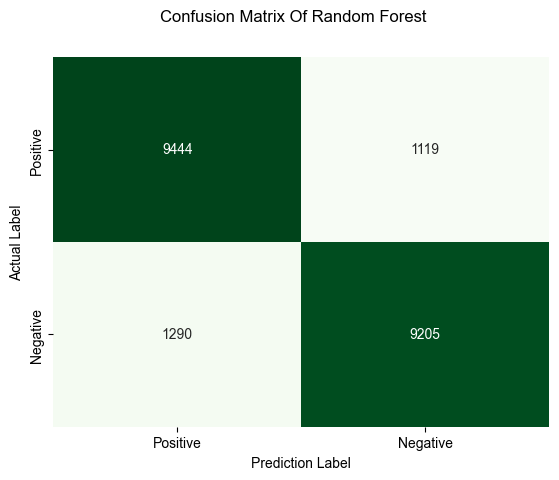

In [74]:
False_PositiveRF, True_PositiveRF, False_NegativeRF, True_NegativeRF = generate_poitive_negative(y_test=y_test, y_pred=y_predRF)
ConfusionMatrixRF = confusion_matrix_(true_positive = True_PositiveRF, true_negative = True_NegativeRF, false_positive =False_PositiveRF, false_negative = False_NegativeRF)
confusion_matrix_display(confusion_matrix = ConfusionMatrixRF, name = 'Random Forest')

In [75]:
AccuracyRF = accuracy_score(True_Positive = True_PositiveRF, True_Negative = True_NegativeRF, False_Positive =False_PositiveRF, False_Negative = False_NegativeRF)
PrecisionRF= precision_score(True_Positive = True_PositiveRF, False_Positive =False_PositiveRF)

SensitivityRF = sensitivity_score(True_Positive = True_PositiveRF,  False_Negative = False_NegativeRF)
SpecificityRF = specificity_score(True_Negative = True_NegativeRF, False_Positive = False_PositiveRF)

F1ScoreRF = f1_score(True_Positive = True_PositiveRF, False_Negative = False_NegativeRF, False_Positive = False_PositiveRF)
ErrorRF = error_rate(True_Positive = True_PositiveRF, True_Negative = True_NegativeRF, False_Positive =False_PositiveRF, False_Negative = False_NegativeRF)

In [76]:
performance_metrics_data_frame(Accuracy = AccuracyRF, Precision = PrecisionRF, Sensitivity = SensitivityRF, Specificity = SpecificityRF, F1Score = F1ScoreRF, Error = ErrorRF)

,Values
Accuracy,0.885602
Precision,0.894064
Sensitivity,0.879821
Specificity,0.891612
F1Score,0.886885
Error,0.114398


**6-SGD Classifier**

In [77]:
Algorithm = SGDClassifier(loss='hinge')
model_6 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_6, X_train=X_train_vec, y_train=y_train)

SGDClassifier()

In [78]:
y_predSGD = model_6.predict(X_test_vec)

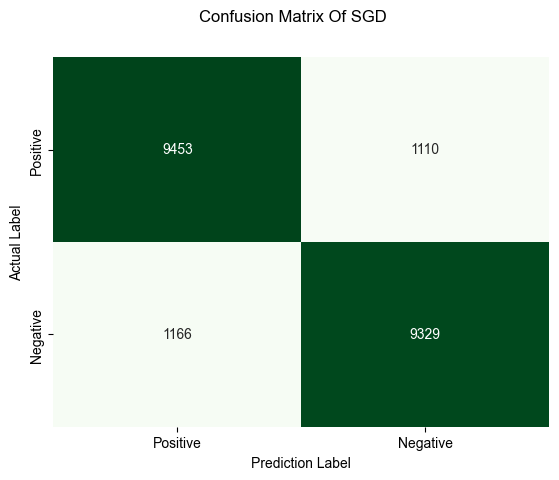

In [79]:
False_PositiveSGD, True_PositiveSGD, False_NegativeSGD, True_NegativeSGD = generate_poitive_negative(y_test=y_test, y_pred=y_predSGD)
ConfusionMatrixSGD = confusion_matrix_(true_positive = True_PositiveSGD, true_negative = True_NegativeSGD, false_positive =False_PositiveSGD, false_negative = False_NegativeSGD)
confusion_matrix_display(confusion_matrix = ConfusionMatrixSGD, name = 'SGD')

In [80]:
AccuracySGD = accuracy_score(True_Positive = True_PositiveSGD, True_Negative = True_NegativeSGD, False_Positive =False_PositiveSGD, False_Negative = False_NegativeSGD)
PrecisionSGD= precision_score(True_Positive = True_PositiveSGD, False_Positive =False_PositiveSGD)

SensitivitySGD = sensitivity_score(True_Positive = True_PositiveSGD,  False_Negative = False_NegativeSGD)
SpecificitySGD = specificity_score(True_Negative = True_NegativeSGD, False_Positive = False_PositiveSGD)

F1ScoreSGD = f1_score(True_Positive = True_PositiveSGD, False_Negative = False_NegativeSGD, False_Positive = False_PositiveSGD)
ErrorSGD = error_rate(True_Positive = True_PositiveSGD, True_Negative = True_NegativeSGD, False_Positive =False_PositiveSGD, False_Negative = False_NegativeSGD)

In [81]:
performance_metrics_data_frame(Accuracy = AccuracySGD, Precision = PrecisionSGD, Sensitivity = SensitivitySGD, Specificity = SpecificitySGD, F1Score = F1ScoreSGD, Error = ErrorSGD)

,Values
Accuracy,0.891918
Precision,0.894916
Sensitivity,0.890197
Specificity,0.893668
F1Score,0.892550
Error,0.108082


# Deep Learning

**1.Preprocessing**

In [82]:
tokenizer, vocab_size, max_length, encoded_X_train , encoded_X_test, encoded_y_train, encoded_y_test, word_index= deeplearning_preprcosesing_(X_train=X_train, X_test=X_test,  truncating='pre', padding='pre', y_train_=y_train, y_test_=y_test)

In [83]:
print('The Vocab Size Is :',vocab_size)
print('')
print('The Max Length Is :', max_length)

The Vocab Size Is : 92759

The Max Length Is : 373


**2.Word Index**

In [84]:
Word_Index = word_index
Word_Index_ =pd.DataFrame(((list(Word_Index.items()))), columns=['Word', 'Index'])
Word_Index_.head()

,Word,Index
0,<oov>,1
1,الفندق,2
2,الغرفه,3
3,شي,4
4,الاستقبال,5


**3.Generate Word Vector**

In [85]:
path = './full_grams_cbow_100_twitter/full_grams_cbow_100_twitter.mdl'
word_vector = word_vector_(model_path = path, vocab_size = vocab_size + 1, embedding_dim = 100, tokenizer = tokenizer)

# Deep Learing Models

**7-LSTM**

Epoch 1/50
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 244s 92ms/step - accuracy: 0.7037 - loss: 0.5355 - val_accuracy: 0.8833 - val_loss: 0.2824 - learning_rate: 1.0000e-04
Epoch 2/50
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 243s 92ms/step - accuracy: 0.8895 - loss: 0.2682 - val_accuracy: 0.8930 - val_loss: 0.2559 - learning_rate: 1.0000e-04
Epoch 3/50
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 235s 89ms/step - accuracy: 0.9008 - loss: 0.2384 - val_accuracy: 0.8985 - val_loss: 0.2445 - learning_rate: 1.0000e-04
Epoch 4/50
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 244s 93ms/step - accuracy: 0.9090 - loss: 0.2207 - val_accuracy: 0.9014 - val_loss: 0.2371 - learning_rate: 1.0000e-04
Epoch 5/50
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 244s 93ms/step - accuracy: 0.9149 - loss: 0.2075 - val_accuracy: 0.9033 - val_loss: 0.2324 - learning_rate: 1.0000e-04
Epoch 6/50
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 247s 94ms/step - accuracy: 0.9198 - loss: 0.1965 - val_accuracy: 0.9047 - val_loss: 0.2293 - learning_rate: 1.0000e-04
Epoch 7/50
2633/2633 ━━━━━━━━━━━━━

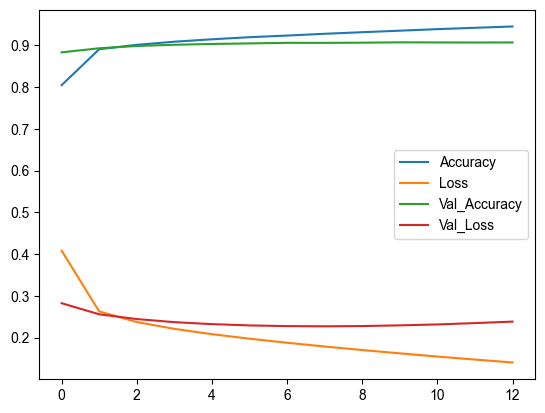

In [86]:
model_7 =lstm_(vocab_size = vocab_size + 1, embedding_dim = 100, max_length = max_length, units = 32, embeddings_matrix = word_vector)
model_compile(model=model_7)
history = model_fit(model=model_7, X_train=encoded_X_train, y_train=y_train, epochs=50, X_test=encoded_X_test, y_test=y_test, batch_size=32)
plot_changes(histoty=history)  

**8-GRU**

Epoch 1/50
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 258s 97ms/step - accuracy: 0.6278 - loss: 0.6267 - val_accuracy: 0.8810 - val_loss: 0.2862 - learning_rate: 1.0000e-04
Epoch 2/50
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 256s 97ms/step - accuracy: 0.8895 - loss: 0.2711 - val_accuracy: 0.8947 - val_loss: 0.2527 - learning_rate: 1.0000e-04
Epoch 3/50
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 255s 97ms/step - accuracy: 0.9034 - loss: 0.2363 - val_accuracy: 0.8997 - val_loss: 0.2389 - learning_rate: 1.0000e-04
Epoch 4/50
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 255s 97ms/step - accuracy: 0.9110 - loss: 0.2174 - val_accuracy: 0.9035 - val_loss: 0.2305 - learning_rate: 1.0000e-04
Epoch 5/50
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 258s 98ms/step - accuracy: 0.9174 - loss: 0.2036 - val_accuracy: 0.9051 - val_loss: 0.2256 - learning_rate: 1.0000e-04
Epoch 6/50
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 255s 97ms/step - accuracy: 0.9229 - loss: 0.1923 - val_accuracy: 0.9066 - val_loss: 0.2226 - learning_rate: 1.0000e-04
Epoch 7/50
2633/2633 ━━━━━━━━━━━━━

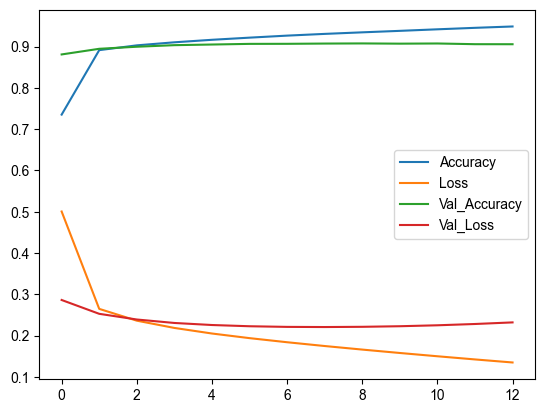

In [87]:
model_8 = gru_(vocab_size = vocab_size + 1, embedding_dim = 100, max_length = max_length, units = 32,  embeddings_matrix = word_vector)
model_compile(model=model_8)
history = model_fit(model=model_8, X_train=encoded_X_train, y_train=y_train, epochs=50, X_test=encoded_X_test, y_test=y_test, batch_size=32)
plot_changes(histoty=history)

**9-Bidirectional LSTM**

Epoch 1/5
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 515s 195ms/step - accuracy: 0.7731 - loss: 0.4592 - val_accuracy: 0.8894 - val_loss: 0.2629 - learning_rate: 1.0000e-04
Epoch 2/5
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 530s 201ms/step - accuracy: 0.8959 - loss: 0.2481 - val_accuracy: 0.8982 - val_loss: 0.2408 - learning_rate: 1.0000e-04
Epoch 3/5
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 521s 198ms/step - accuracy: 0.9070 - loss: 0.2224 - val_accuracy: 0.9031 - val_loss: 0.2315 - learning_rate: 1.0000e-04
Epoch 4/5
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 513s 195ms/step - accuracy: 0.9144 - loss: 0.2067 - val_accuracy: 0.9064 - val_loss: 0.2261 - learning_rate: 1.0000e-04
Epoch 5/5
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 490s 186ms/step - accuracy: 0.9204 - loss: 0.1947 - val_accuracy: 0.9076 - val_loss: 0.2233 - learning_rate: 1.0000e-04


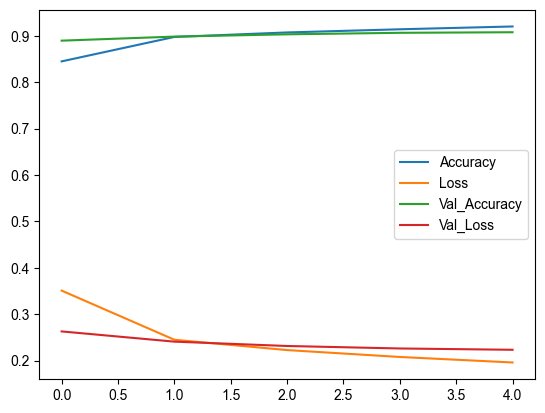

In [88]:
model_9=bidirectional_lstm(vocab_size = vocab_size + 1, embedding_dim = 100, max_length = max_length, units = 64, embeddings_matrix = word_vector)
model_compile(model=model_9)
history = model_fit(model=model_9, X_train=encoded_X_train, y_train=y_train, epochs=5, X_test=encoded_X_test, y_test=y_test, batch_size=32)
plot_changes(histoty=history)

# Model Inference

**1-Naive Bayes**

In [89]:
machine_learning_inference(model=model_1,vectorizer=Vectorizer, text = reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Negative

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Negative

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**2-Logistic Regression**

In [90]:
machine_learning_inference(model=model_2,vectorizer=Vectorizer, text = reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Positive

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Positive

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**3-Decision Tree**

In [91]:
machine_learning_inference(model=model_3,vectorizer=Vectorizer, text = reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Positive

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Negative

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Negative

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Negative

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**4-K Nearest Neighbors**

In [92]:
machine_learning_inference(model=model_4,vectorizer=Vectorizer, text = reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Negative

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Positive

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Negative

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**5-Random Forest**

In [93]:
machine_learning_inference(model=model_5,vectorizer=Vectorizer, text = reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Positive

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Negative

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**6-SGD Classifier**

In [94]:
machine_learning_inference(model=model_6,vectorizer=Vectorizer, text = reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Positive

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Positive

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**7-LSTM**

In [95]:
deep_learning_inference(model = model_7, text = reviews,  tokenizer = tokenizer, max_length = max_length)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Negative

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Negative

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Negative

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Negative

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**8-Bidirectional LSTM**

In [96]:
deep_learning_inference(model = model_8, text = reviews , tokenizer = tokenizer, max_length = max_length)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Negative

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**9-GRU**

In [97]:
deep_learning_inference(model = model_9, text = reviews , tokenizer = tokenizer, max_length = max_length)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Positive

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Positive

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

# Transformers

In [4]:
sentiment_analysis_transformers(reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Negative

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ